In [1]:
import os
import pandas as pd
import numpy as np
import itertools
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

2023-12-22 12:22:17.091409: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-22 12:22:18.682043: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-22 12:22:18.682967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 12:22:23.778962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATA_DIR = './dms_data'
N_TRIALS = 50

In [3]:

def load_and_preprocess_data(file_path):
  """CSVを読み込んで前処理する関数。"""
  df = pd.read_csv(file_path)
  df = df.drop(['timestamp'], axis=1)
  return df.dropna()


def get_data_from_directory(directory_path):
  """指定ディレクトリのCSV全部を読み込んで結合する関数。"""
  files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
  data_frames = [load_and_preprocess_data(os.path.join(directory_path, file)) for file in files]
  return pd.concat(data_frames, ignore_index=True)


# トレインデータとテストデータを読み込む
train = get_data_from_directory(os.path.join(DATA_DIR, 'train'))
test = get_data_from_directory(os.path.join(DATA_DIR, 'test'))

# 特徴量を定義
features = [
    'm_speed', 'm_speed_var_480', 'm_speed_stddev_480', 'm_acceleration',
    'm_acceleration_var_480', 'm_acceleration_stddev_480', 'm_jerk',
    'm_jerk_var_480', 'm_jerk_stddev_480'
]


def evaluate_model(model, X, y):
  """モデルの評価。RMSE"""
  predictions = model.predict(X)
  return np.sqrt(mean_squared_error(y, predictions))


def printResults(rmse_results, title):
  mean_rmse = np.mean(rmse_results)
  median_rmse = np.median(rmse_results)
  variance_rmse = np.var(rmse_results)
  std_rmse = np.std(rmse_results)
  min_rmse = np.min(rmse_results)
  max_rmse = np.max(rmse_results)

  # 統計量を表示
  print(f"[{title}]RMSEの平均値: {mean_rmse}")
  print(f"[{title}]RMSEの中央値: {median_rmse}")
  print(f"[{title}]RMSEの分散: {variance_rmse}")
  print(f"[{title}]RMSEの標準偏差: {std_rmse}")
  print(f"[{title}]RMSEの最小値: {min_rmse}")
  print(f"[{title}]RMSEの最大値: {max_rmse}")

In [4]:
# print(train_data.head())
# print(train_data.describe())

data_dir = DATA_DIR  # データのディレクトリパス
data_lengths = []

# `test` と `train` ディレクトリ内の各CSVファイルのデータ長を確認
for dataset_type in ['test', 'train']:
  dataset_path = os.path.join(data_dir, dataset_type)
  csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
  for csv_file in csv_files:
    csv_path = os.path.join(dataset_path, csv_file)
    df = pd.read_csv(csv_path)
    data_lengths.append((dataset_type, csv_file, len(df)))
print(data_lengths)
# データの長さが最小のものを確認
min_length_data = min(data_lengths, key=lambda x: x[2])
min_length_data

[('test', '20201126_1546_0_y_test.csv', 36), ('test', '20201127_1432_7_y_test.csv', 35), ('test', '20201127_1548_2_y_test.csv', 36), ('test', '20201127_1701_7_y_test.csv', 35), ('test', '20201127_1840_5_y_test.csv', 36), ('test', '20201130_1122_5_y_test.csv', 37), ('test', '20201130_1808_6_y_test.csv', 37), ('test', '20201201_1230_0_y_test.csv', 37), ('test', '20201201_1429_5_y_test.csv', 36), ('test', '20201201_1555_0_y_test.csv', 36), ('test', '20201203_1022_7_y_test.csv', 36), ('test', '20201203_1244_5_y_test.csv', 36), ('test', '20201203_1404_6_y_test.csv', 36), ('test', '20201210_1112_2_y_test.csv', 35), ('test', '20201210_1354_2_y_test.csv', 35), ('test', '20201210_1610_6_y_test.csv', 38), ('train', '20201126_1546_0_y_train.csv', 144), ('train', '20201127_1432_7_y_train.csv', 141), ('train', '20201127_1548_2_y_train.csv', 146), ('train', '20201127_1701_7_y_train.csv', 141), ('train', '20201127_1840_5_y_train.csv', 145), ('train', '20201130_1122_5_y_train.csv', 151), ('train', '20

('test', '20201127_1432_7_y_test.csv', 35)

In [5]:
# 被験者 `20201127_1432_7` のデータを除外する
excluded_subj = '20201127_1432_7'
filtered_data_lengths = [(dataset_type, csv_file, length) for dataset_type, csv_file, length in data_lengths if excluded_subj not in csv_file]

# 除外後のデータを確認
filtered_data_lengths


[('test', '20201126_1546_0_y_test.csv', 36),
 ('test', '20201127_1548_2_y_test.csv', 36),
 ('test', '20201127_1701_7_y_test.csv', 35),
 ('test', '20201127_1840_5_y_test.csv', 36),
 ('test', '20201130_1122_5_y_test.csv', 37),
 ('test', '20201130_1808_6_y_test.csv', 37),
 ('test', '20201201_1230_0_y_test.csv', 37),
 ('test', '20201201_1429_5_y_test.csv', 36),
 ('test', '20201201_1555_0_y_test.csv', 36),
 ('test', '20201203_1022_7_y_test.csv', 36),
 ('test', '20201203_1244_5_y_test.csv', 36),
 ('test', '20201203_1404_6_y_test.csv', 36),
 ('test', '20201210_1112_2_y_test.csv', 35),
 ('test', '20201210_1354_2_y_test.csv', 35),
 ('test', '20201210_1610_6_y_test.csv', 38),
 ('train', '20201126_1546_0_y_train.csv', 144),
 ('train', '20201127_1548_2_y_train.csv', 146),
 ('train', '20201127_1701_7_y_train.csv', 141),
 ('train', '20201127_1840_5_y_train.csv', 145),
 ('train', '20201130_1122_5_y_train.csv', 151),
 ('train', '20201130_1808_6_y_train.csv', 152),
 ('train', '20201201_1230_0_y_train.c

In [6]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.fbprophet import Prophet
from sklearn.ensemble import RandomForestRegressor

# RandomForestの定義
regressor = RandomForestRegressor()
rf = make_reduction(
    regressor,
    strategy="recursive",
    window_length=12,
    scitype="infer",
)

# ARIMAの定義
arima = AutoARIMA(sp=12, suppress_warnings=True)

# Prophetの定義
prophet = Prophet()

models = {
    "RandomForest": rf,
    "ARIMA": arima,
    "Prophet": prophet
}

Importing plotly failed. Interactive plots will not work.


In [7]:
data_dir = DATA_DIR
data = {}
for dataset_type in ['test', 'train']:
  dataset_path = os.path.join(data_dir, dataset_type)
  for csv_file in os.listdir(dataset_path):
    if csv_file.endswith(".csv") and "20201127_1432_7" not in csv_file:  # 短いデータの除外
      file_path = os.path.join(dataset_path, csv_file)
      df = pd.read_csv(file_path)
      df.index = range(len(df))  # インデックスを0からの連番に変更
      data[(dataset_type, csv_file)] = df

In [8]:
print("checking")
print(type(data))

checking
<class 'dict'>


28 8
28 8
28 7
28 8
29 8
29 8
29 8
28 8
28 8
28 8
28 8
28 8
28 7
28 7
30 8
115 29
116 30
112 29
116 29
120 31
121 31
119 30
116 29
115 29
115 29
115 29
115 29
115 29
114 29
121 31


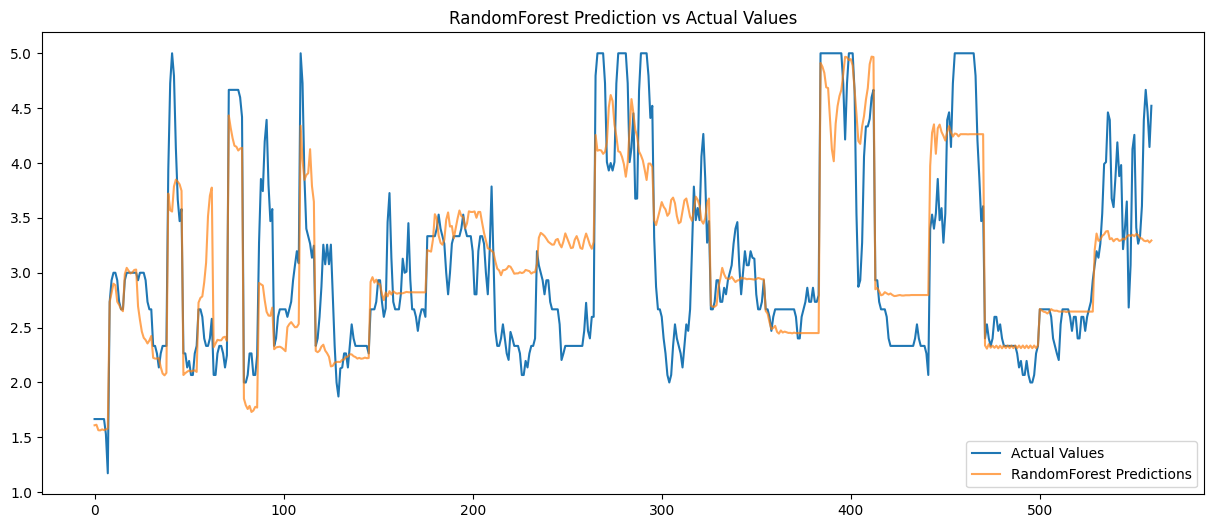

28 8


12:22:42 - cmdstanpy - INFO - Chain [1] start processing
12:22:42 - cmdstanpy - INFO - Chain [1] done processing
12:22:42 - cmdstanpy - INFO - Chain [1] start processing
12:22:43 - cmdstanpy - INFO - Chain [1] done processing
12:22:43 - cmdstanpy - INFO - Chain [1] start processing


28 8
28 7


12:22:43 - cmdstanpy - INFO - Chain [1] done processing
12:22:43 - cmdstanpy - INFO - Chain [1] start processing
12:22:43 - cmdstanpy - INFO - Chain [1] done processing
12:22:43 - cmdstanpy - INFO - Chain [1] start processing


28 8
29 8


12:22:43 - cmdstanpy - INFO - Chain [1] done processing
12:22:43 - cmdstanpy - INFO - Chain [1] start processing
12:22:43 - cmdstanpy - INFO - Chain [1] done processing
12:22:43 - cmdstanpy - INFO - Chain [1] start processing


29 8
29 8


12:22:43 - cmdstanpy - INFO - Chain [1] done processing
12:22:43 - cmdstanpy - INFO - Chain [1] start processing
12:22:43 - cmdstanpy - INFO - Chain [1] done processing
12:22:43 - cmdstanpy - INFO - Chain [1] start processing


28 8
28 8


12:22:44 - cmdstanpy - INFO - Chain [1] done processing
12:22:44 - cmdstanpy - INFO - Chain [1] start processing
12:22:44 - cmdstanpy - INFO - Chain [1] done processing
12:22:44 - cmdstanpy - INFO - Chain [1] start processing


28 8
28 8


12:22:44 - cmdstanpy - INFO - Chain [1] done processing
12:22:44 - cmdstanpy - INFO - Chain [1] start processing
12:22:44 - cmdstanpy - INFO - Chain [1] done processing
12:22:44 - cmdstanpy - INFO - Chain [1] start processing


28 8
28 7


12:22:44 - cmdstanpy - INFO - Chain [1] done processing
12:22:44 - cmdstanpy - INFO - Chain [1] start processing
12:22:44 - cmdstanpy - INFO - Chain [1] done processing
12:22:44 - cmdstanpy - INFO - Chain [1] start processing


28 7
30 8


12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing


115 29
116 30
112 29


12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing


116 29
120 31
121 31


12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:45 - cmdstanpy - INFO - Chain [1] start processing


119 30
116 29
115 29


12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:45 - cmdstanpy - INFO - Chain [1] start processing
12:22:45 - cmdstanpy - INFO - Chain [1] done processing
12:22:46 - cmdstanpy - INFO - Chain [1] start processing
12:22:46 - cmdstanpy - INFO - Chain [1] done processing


115 29
115 29
115 29


12:22:46 - cmdstanpy - INFO - Chain [1] start processing
12:22:46 - cmdstanpy - INFO - Chain [1] done processing
12:22:46 - cmdstanpy - INFO - Chain [1] start processing
12:22:46 - cmdstanpy - INFO - Chain [1] done processing


115 29
114 29


12:22:46 - cmdstanpy - INFO - Chain [1] start processing
12:22:46 - cmdstanpy - INFO - Chain [1] done processing


121 31


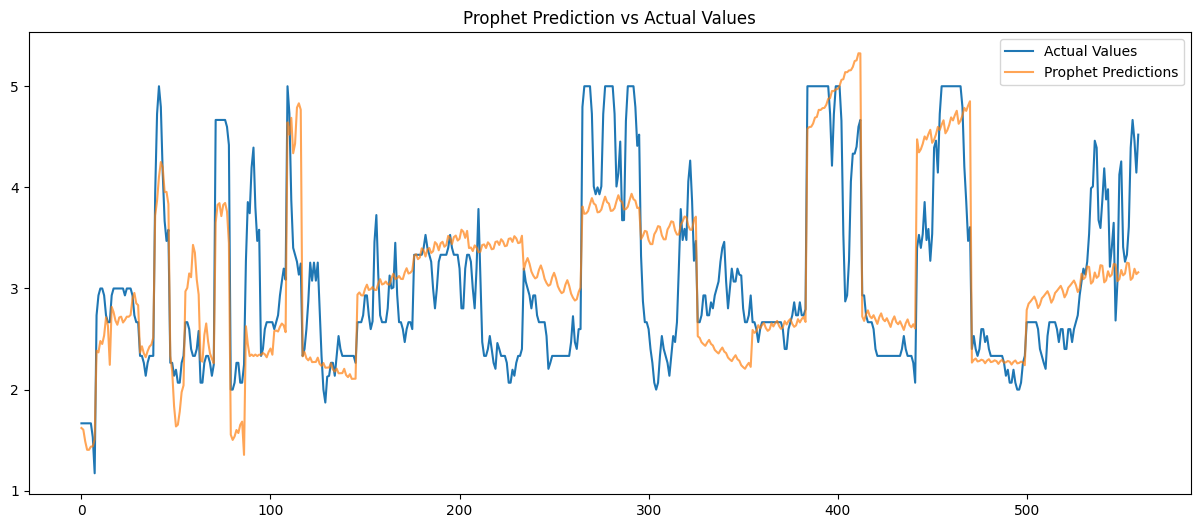

{'RandomForest': 0.2734762659369484, 'Prophet': 0.40374425871823344}

In [9]:
results = {}
predictions = {}
actual_values = {}
split_ratio = 0.8

for model_name, model in models.items():
  if (model_name == "ARIMA"):
    continue
  all_errors = []
  all_preds = []
  all_actual = []

  for (dataset_type, csv_file), df in data.items():
    split_point = int(len(df) * split_ratio)
    y_train = df["oss"][:split_point]
    y_test = df["oss"][split_point:]
    if y_train.isna().any() or y_test.isna().any():
      print(f"Warning: NaN values detected in {dataset_type}/{csv_file}")
      continue
    print(len(y_train), len(y_test))
    try:
      model.fit(y_train)
    except ValueError as e:
      print(f"Error with {dataset_type}/{csv_file}: {e}")
    y_pred = model.predict(fh=range(1, len(y_test) + 1))
    if np.isnan(y_pred).any():
      print(f"Warning: NaN predictions from {model_name} for {dataset_type}/{csv_file}")
      continue

    all_preds.extend(y_pred)
    all_actual.extend(y_test)

    error = mean_squared_error(y_test, y_pred)
    all_errors.append(error)
  results[model_name] = np.mean(all_errors)
  predictions[model_name] = all_preds
  actual_values[model_name] = all_actual
  plt.figure(figsize=(15, 6))
  plt.plot(all_actual, label="Actual Values")
  plt.plot(all_preds, label=f"{model_name} Predictions", alpha=0.7)
  plt.title(f"{model_name} Prediction vs Actual Values")
  plt.legend()
  plt.show()

results

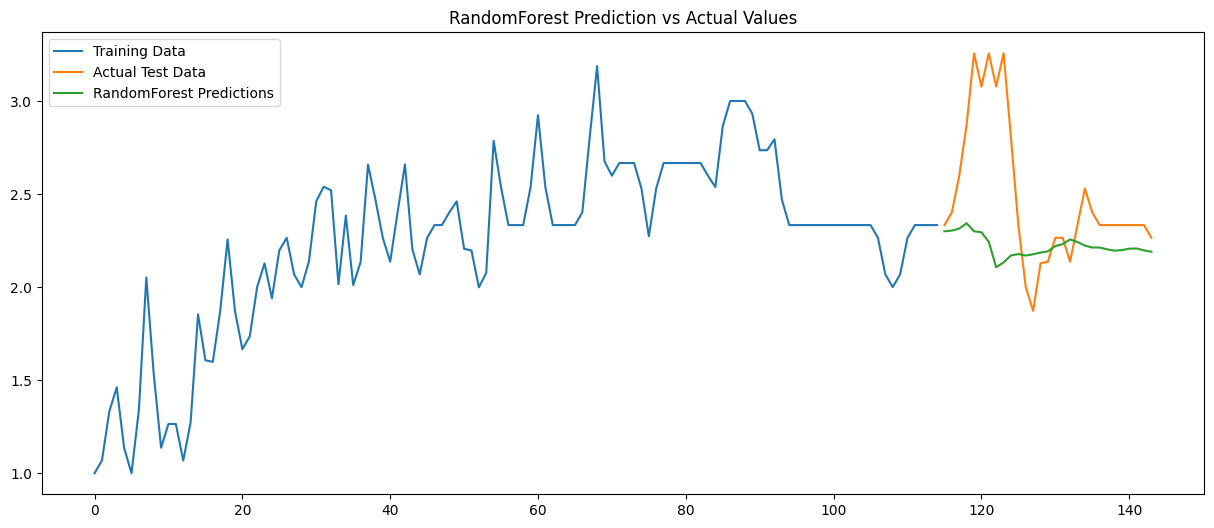

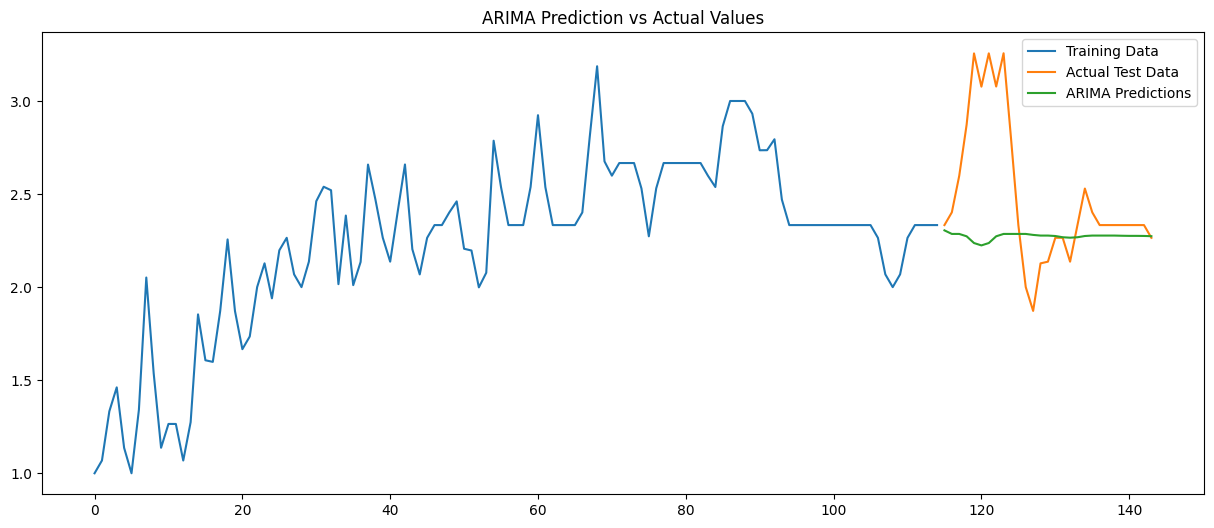

12:23:01 - cmdstanpy - INFO - Chain [1] start processing
12:23:01 - cmdstanpy - INFO - Chain [1] done processing


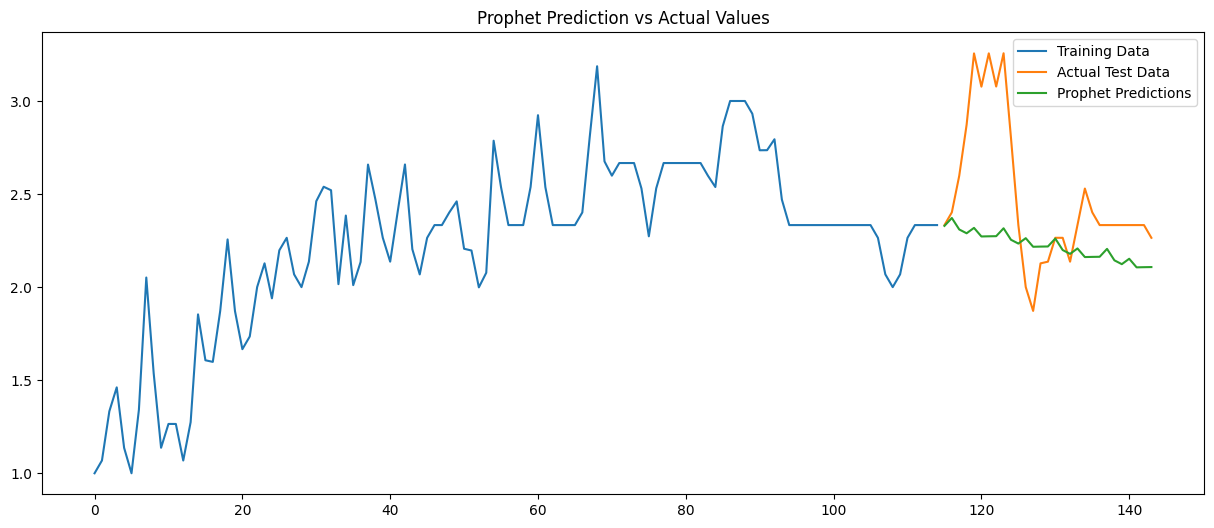

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.fbprophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

csv_file_path = './dms_data/train/20201126_1546_0_y_train.csv'

df = pd.read_csv(csv_file_path)
regressor = RandomForestRegressor()
rf = make_reduction(
    regressor,
    strategy="recursive",
    window_length=12,
    scitype="infer",
)

arima = AutoARIMA(sp=12, suppress_warnings=True)

prophet = Prophet()

models = {
    "RandomForest": rf,
    "ARIMA": arima,
    "Prophet": prophet
}

split_ratio = 0.8
split_point = int(len(df) * split_ratio)
train_data = df[:split_point]
test_data = df[split_point:]

for model_name, model in models.items():
  model.fit(train_data["oss"])  # 学習
  y_pred = model.predict(fh=range(1, len(test_data) + 1))
  plt.figure(figsize=(15, 6))
  plt.plot(np.arange(len(train_data)), train_data["oss"], label="Training Data")
  plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data["oss"], label="Actual Test Data")
  plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), y_pred, label=f"{model_name} Predictions")
  plt.title(f"{model_name} Prediction vs Actual Values")
  plt.legend()
  plt.show()